In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, date, time, timedelta
from functions_anton.functions_models import plot_forecast, step_modification_to_forecast

In [25]:
df_train = pd.read_parquet('parquet_4_testing/train_01.parquet')
df_test = pd.read_parquet('parquet_4_testing/test_01.parquet')

In [26]:
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter

train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
train_end = pd.to_datetime(df_train['date'].iloc[-1])
# The forecast starts immediately after the training data ends
forecast_start_date = train_end + pd.Timedelta(minutes=sampling_rate)
# The forecast extends for 'forecast_days' from its start
forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=sampling_rate)

In [27]:
def baseline_model(data,date="datetime",value="e5",predictions=12*24,stepsize=(5,"minutes"),rule="daily mean"):
    """Predicts fuel prices with a simple model

    Args:
        data (DataFrame): Input dataset
        date (str, optional): Name of the datetime variable. Defaults to "datetime".
        value (str, optional): Name of the prediction variable. Defaults to "e5".
        predictions (int, optional): Number of predictions to make by the model. Defaults to 12*24.
        stepsize (tuple, optional): Time difference between predictions. Defaults to (5,"minutes").
        rule (str, optional): Rule for setting the prediction value. Can be "daily mean" (mean of previous day) or "last value" (last available value). Defaults to "daily mean".

    Returns:
        DataFrame: Prediction dataset
    """

    # Get first and last prediction dat
    if stepsize[1] == "minutes":
        first_date_predict  = data[date].iloc[-1]+timedelta(minutes=stepsize[0])
        last_date_predict = first_date_predict+(timedelta(minutes=(stepsize[0]*predictions)-1))
    elif stepsize[1] == "hours":
        first_date_predict  = data[date].iloc[-1]+timedelta(minutes=stepsize[0])
        last_date_predict = first_date_predict+(timedelta(hours=(stepsize[0]*predictions)-1))
    elif stepsize[1] == "days":
        first_date_predict  = data[date].iloc[-1]+timedelta(minutes=stepsize[0])
        last_date_predict = first_date_predict+(timedelta(days=(stepsize[0]*predictions)-1))

    # Get prediction value
    if rule == "last value":
        pred_value = data[value].iloc[-1]
    elif rule == "daily mean":
        pred_value = data[data[date]>= data[date].iloc[-1]-timedelta(days=1)][value].mean()
    

    # Create DataFrame with new predictions
    df_predict = pd.DataFrame(columns=[date,value])
    df_predict[date] = pd.date_range(start=first_date_predict, end=last_date_predict, freq=timedelta(minutes=stepsize[0]))
    df_predict[value] = pred_value

    return df_predict

1-Day MAE in cent: 5.5186
3-Day MAE in cent: 5.5473
7-Day MAE in cent: 5.1605


(19592.0, 19602.0)

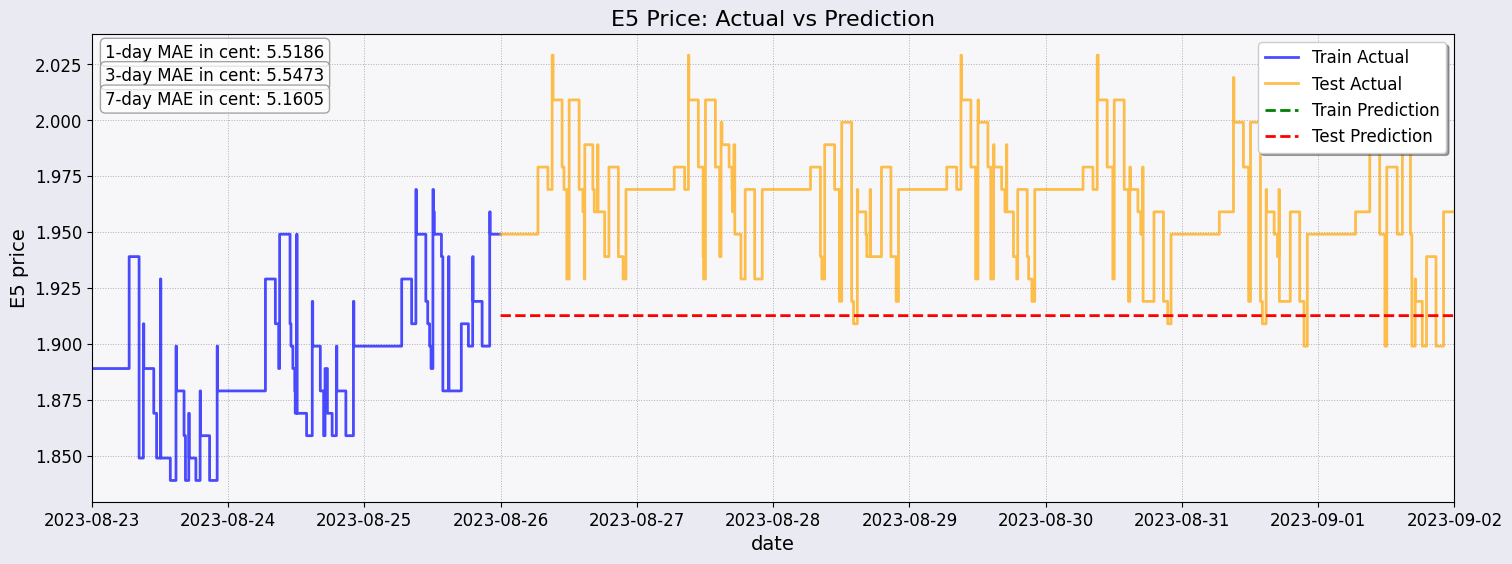

In [28]:
forecast = baseline_model(df_train, 'date', 'e5', forecast_days*1440/sampling_rate, (sampling_rate,"minutes"))

train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)

train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), pd.to_datetime(forecast_end_date.strftime('%Y-%m-%d'))+ pd.Timedelta(days = 1))

plot_forecast(df_train, df_test, None, forecast, forecast, train_dates_plot, test_dates_plot)
plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))